# Buffer Stock Saving in HARK and dolo
<!-- <p style="text-align: center;"><small><small>Generator: BufferStockTheory-make/notebooks_byname</small></small></p>
-->

This notebook compares the solutions to a standard buffer stock saving model obtained by the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit and the [dolo](https://github.com/EconForge/dolo) modeling system.

In [1]:
# This cell does some setup and imports generic tools 
# Much of the material below is unnecessary for present purposes;
# It is inherited from a notebook designed to work on many systems and accomplish many goals
# most of which are not relevant here
# For "ultimately I shoud delete these files purposes:" It was derived from BufferStock-HARK-vs-dolo.ipynb in llorracc/dolo/examples/notebooks

Generator=True # Is this notebook the master or is it generated?
# Import related generic python packages
import numpy as np
from time import clock
mystr = lambda number : "{:.4f}".format(number)

# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"

from IPython import get_ipython # In case it was run from python instead of ipython
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')
    print('You appear to be running from a terminal')
    print('By default, figures will appear one by one')
    print('Close the visible figure in order to see the next one')

# Import the plot-figure library matplotlib

import matplotlib.pyplot as plt

# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.
from matplotlib import rc
plt.rc('font', family='serif')

# LaTeX is huge and takes forever to install on mybinder
# so if it is not installed then do not use it 
from distutils.spawn import find_executable
iflatexExists=False
if find_executable('latex'):
    iflatexExists=True
    
plt.rc('font', family='serif')
plt.rc('text', usetex=iflatexExists)

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

# The tools for navigating the filesystem
import sys
import os

sys.path.insert(0, os.path.abspath('../../lib')) # REMARKs directory is two down from root 

from HARK.utilities import plotFuncsDer, plotFuncs
from copy import copy, deepcopy

# Define (and create, if necessary) the figures directory "Figures"
if Generator:
    my_file_path = os.path.dirname(os.path.abspath("BufferStockTheory.py")) # Find pathname to this file:
    Figures_HARK_dir = os.path.join(my_file_path,"Figures/") # LaTeX document assumes figures will be here
    Figures_HARK_dir = os.path.join(my_file_path,"/tmp/Figures/") # Uncomment to make figures outside of git path
    if not os.path.exists(Figures_HARK_dir):
        os.makedirs(Figures_HARK_dir)

## [The Problem](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem) 

[This paper](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem) defines a buffer stock saving model and calibrates parameters:

| Parameter | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\newcommand{\PermGroFac}{\Gamma}\PermGroFac$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.03 |
| $\newcommand{\Rfree}{\mathrm{\mathsf{R}}}\Rfree$ | Interest Factor | $\texttt{Rfree}$ | 1.04 |
| $\newcommand{\DiscFac}{\beta}\DiscFac$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
| $\newcommand{\CRRA}{\rho}\CRRA$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
| $\newcommand{\UnempPrb}{\wp}\UnempPrb$ | Probability of Unemployment | $\texttt{UnempPrb}$ | 0.005 |
| $\newcommand{\IncUnemp}{\mu}\IncUnemp$ | Income when Unemployed | $\texttt{IncUnemp}$ | 0. |
| $\newcommand{\PermShkStd}{\sigma_\psi}\PermShkStd$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.1 |
| $\newcommand{\TranShkStd}{\sigma_\theta}\TranShkStd$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.1 |

For a microeconomic consumer with 'Market Resources' $M_{t}$ (net worth plus current income; basically, everything the consumer owns), end-of-period assets $A_{t}$ will be the amount remaining after consuming $C_{t}$:  <!-- Next period's 'Balances' $B_{t+1}$ reflect this period's $A_{t}$ augmented by return factor $R$:-->
\begin{eqnarray}
A_{t}   &=&M_{t}-C_{t}.  \label{eq:DBCparts}
\end{eqnarray}

The consumer's permanent noncapital income $P$ (in the sense of [Friedman (1957)](http://www.econ2.jhu.edu/people/ccarroll/ATheoryv3NBER.pdf)) grows by a predictable factor $\PermGroFac$ and is subject to an unpredictable lognormally distributed multiplicative shock $\mathbb{E}_{t}[\psi_{t+1}]=1$, 
\begin{eqnarray}
P_{t+1} & = & P_{t} \PermGroFac \psi_{t+1}
\end{eqnarray}
and actual income is permanent income multiplied by a logormal multiplicative transitory shock, $\mathbb{E}_{t}[\theta_{t+1}]=1$, so that next period's market resources are
\begin{eqnarray}
%M_{t+1} &=& B_{t+1} +P_{t+1}\theta_{t+1},  \notag
M_{t+1} &=& A_{t}R +P_{t+1}\theta_{t+1}.  \notag
\end{eqnarray}

When the consumer has a standard Constant Relative Risk Aversion utility function $u(c)=\frac{c^{1-\rho}}{1-\rho}$, [the paper shows](http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem-Can-Be-Rewritten-in-Ratio-Form) that the problem can be written in terms of ratios of money variables to permanent income, e.g. $m_{t} \equiv M_{t}/P_{t}$, and the Bellman form of [the problem reduces to](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Related-Problem):

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~~ u(c_t) + \beta~\mathbb{E}_{t} [(\Gamma\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ] \\
& s.t. & \\
a_t &=& m_t - c_t \\
m_{t+1} &=& R/(\Gamma \psi_{t+1}) a_t + \theta_{t+1} \\
\end{eqnarray*}

and the [Euler equation](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/Consumption/Envelope) for this model is 

\begin{align*}
c_{t}^{-\rho} & = R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1})^{-\rho})] %\\
% 0 & = & R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1}/c_{t})^{-\rho})]-1
\end{align*}


For the purposes of this notebook, [the paper's](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory) baseline [parameterization](http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Baseline-Numerical-Solution) is changed as follows:

1. The unemployment (zero-income event) shocks are turned off
2. An explicit liqudity constraint is added ($c_{t} \leq m_{t}$); that is, the consumer is prohibited from borrowing, and consumption must always be greater than zero

# Dolo

[Installation instructions](https://github.com/EconForge/dolo/wiki/Installation) for dolo involve a number of dependencies, including the dolo language "dolang."  This notebook assumes all these have been installed.

In [2]:
import dolang
from dolo import *

Dolo defines models using "model files" whose syntax is specified in the documentation

In [3]:
import sys
import os
os.getcwd()

'/Volumes/Data/Code/ARK/DARKolo/chimeras/BufferStock'

In [4]:
model_dolo = yaml_import("./bufferstock.yaml")
print( model_dolo )

# Obtain the decision rule by time iteration
dr = time_iteration(model_dolo,tol=1e-08,verbose=True)


        Model:
        ------
        name: "anonymous"
        type: "dtcc"
        file: "./bufferstock.yaml

Equations:
----------

transition
 1  : 1.7554 : m(0) == exp(tran(0)) + ((m(-(1))) - (c(-(1)))) * ((R) / ((Γ) * (exp(perm(0)))))

arbitrage
 1  : -0.8726 : (((R) * (β)) * (((((c(1)) * (exp(perm(1)))) * (Γ)) / (c(0))) ** (-(ρ)))) - (1)

definitions


------------------------------------------------
| N   |  Error     | Gain     | Time     | nit |
------------------------------------------------
|   1 |  9.000e-01 |      nan |    0.183 |   5 |
|   2 |  2.622e-02 |    0.029 |    0.134 |   5 |
|   3 |  1.962e-02 |    0.748 |    0.152 |   5 |
|   4 |  1.979e-02 |    1.009 |    0.138 |   5 |
|   5 |  2.098e-02 |    1.060 |    0.145 |   5 |
|   6 |  2.335e-02 |    1.113 |    0.145 |   5 |
|   7 |  2.546e-02 |    1.090 |    0.139 |   5 |
|   8 |  2.664e-02 |    1.046 |    0.082 |   3 |
|   9 |  2.575e-02 |    0.966 |    0.071 |   3 |
|  10 |  2.378e-02 |    0.924 |    0.077 |   3 |


## Explaining the Dolo Model File

Each item in the dolo yaml file corresponds to an equation in the formal mathematics of the BufferStockTheory problem.

### arbitrage

The first such item we want to consider is labelled `arbitrage`.  In Dolo, the arbitrage equation represents a condition that should be equal to zero for an optimizing agent.  Furthermore, items with a future date (like `c(1)` which is equal to $c_{t+1}$ in the usual mathematical notation) are implicitly items whose expectation is being taken.  Dolo's specification of the model defines `perm` as the logarithm of what is called $\psi$, so `exp(perm(1))` is equivalent to $\psi_{t+1}$.  Finally, the expression `| 0.0 <= c <= m` corresponds to the liquidity constraint mentioned above (mathematically, $0 \leq c \leq m$). Thus, the equation below is how dolo represents the equation above:

    arbitrage:
        - (R*β*((c(1)*exp(perm(1))*Γ)/c)^(-ρ)-1 ) | 0.0<=c<=m

This equation is derived from the Euler equation described above, which can be rewritten as:

\begin{align*}
c_{t}^{-\rho} & = R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1})^{-\rho})] \\
% 0 & = & R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1}/c_{t})^{-\rho})]-1
1 & = R \beta \mathbb{E}_{t}[(\Gamma \psi \frac{c_{t+1}}{c_{t}})^{-\rho})] 
\\
0 & = R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1}/c_{t})^{-\rho})]-1
\end{align*}

### transition

The second equation in the `dolang` model is:

    transition:
        - m = exp(tran) + (m(-1)-c(-1))*(R/(Γ*exp(perm)))

Recall that the Bellman form of the original problem is:

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~~ u(c_t) + \beta~\mathbb{E}_{t} [(\Gamma\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ] \\
& s.t. & \\
a_t &=& m_t - c_t \\
m_{t+1} &=& R/(\Gamma \psi_{t+1}) a_t + \theta_{t+1} \\
\end{eqnarray*}

Substituting the first condition, defining $a_t$, into the second, and rearranging, we get:

\begin{eqnarray}
m_{t+1} &=& \theta_{t+1} +  (m_t - c_t) R/(\Gamma \psi_{t+1})
\end{eqnarray}

In the `dolang` model, `tran == 1.0`; this is the mean of the transitory shock $\theta$. `exp(tran)` is $e$, the Euler number.

# HARK
The [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit's solution to this problem is part of the $\texttt{ConsIndShockModel.py}$ module in the $\texttt{ConsumptionSaving}$ directory of tools.  For an introduction to this module, see the [ConsIndShockModel.ipynb](https://econ-ark.org/notebooks) notebook at the [Econ-ARK](https://econ-ark.org) website.

In [5]:
# Define a parameter dictionary with baseline parameter values

# Set the baseline parameter values 
PermGroFac = 1.03
Rfree      = 1.04
DiscFac    = 0.96
CRRA       = 2.00
UnempPrb   = 0.00
IncUnemp   = 0.0
PermShkStd = 0.1
TranShkStd = 0.1
# Import default parameter values
import HARK.ConsumptionSaving.ConsumerParameters as Params 

# Make a dictionary containing all parameters needed to solve the model
base_params = Params.init_idiosyncratic_shocks

# Set the parameters for the baseline results in the paper
# using the variable values defined in the cell above
base_params['PermGroFac'] = [PermGroFac]   # Permanent income growth factor
base_params['Rfree']      = Rfree          # Interest factor on assets
base_params['DiscFac']    = DiscFac        # Time Preference Factor
base_params['CRRA']       = CRRA           # Coefficient of relative risk aversion
base_params['UnempPrb']   = UnempPrb       # Probability of unemployment (e.g. Probability of Zero Income in the paper)
base_params['IncUnemp']   = IncUnemp       # Induces natural borrowing constraint
base_params['PermShkStd'] = [PermShkStd]   # Standard deviation of log permanent income shocks
base_params['TranShkStd'] = [TranShkStd]   # Standard deviation of log transitory income shocks

# Some technical settings that are not interesting for our purposes
base_params['LivPrb']       = [1.0]   # 100 percent probability of living to next period
base_params['CubicBool']    = True    # Use cubic spline interpolation
base_params['T_cycle']      = 1       # No 'seasonal' cycles
base_params['BoroCnstArt']  = None    # No artificial borrowing constraint

from HARK.utilities import plotFuncsDer, plotFuncs
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

In [6]:
# Create a model identical to the dolo model
# Start with the HARK baseline parameters and modify 
# to be like the dolo model 
base_params_dolo = dict(base_params)
base_params_dolo['BoroCnstArt']  = 0.0    # Liquidity constraint at 0
base_params_dolo['UnempPrb']     = 0      # No point-mass on unemployment state 
base_params_dolo['TranShkCount'] = 5      # Default number of nodes in dolo
base_params_dolo['PermShkCount'] = 5
base_params_dolo['aXtraMax']     = 500  # Use same maximum
base_params_dolo['aXtraCount']   = 100    # How dense to make the grid
base_params_dolo['DiscFac']      = 0.96
#base_params_dolo['CubicBool']    = False
model_HARK = IndShockConsumerType(**base_params_dolo,cycles=0) # cycles=0 indicates infinite horizon

In [7]:
# Solve the HARK model 
model_HARK.updateIncomeProcess()
model_HARK.solve()
model_HARK.UnempPrb = 0.05
model_HARK.unpackcFunc()

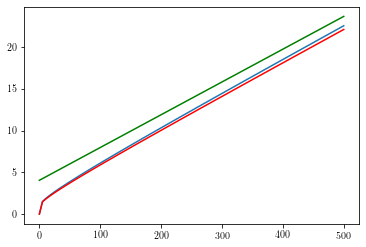

In [8]:
# Plot the results: Green is perfect foresight, red is HARK, black is dolo

tab = tabulate(model_dolo, dr, 'm')
plt.plot(tab['m'],tab['c'])     # This is pretty cool syntax
m = tab.iloc[:,2]
c_m  = model_HARK.cFunc[0](m)   
# cPF uses the analytical formula for the perfect foresight solution
cPF = (np.array(m)-1+1/(1-PermGroFac/Rfree))*((Rfree-(Rfree * DiscFac)**(1/CRRA))/Rfree)
plt.plot(tab['m'],c_m,color="red")
plt.plot(m,cPF,color="green")

### [Upper and Lower Limits of the Marginal Propensity to Consume](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#MPCLimits)

The paper shows that as $m_{t}~\uparrow~\infty$ the consumption function in the presence of risk gets arbitrarily close to the perfect foresight consumption function.  Defining \underline{κ}
as the perfect foresight model's MPC, this implies that $\lim_{m_{t}~\uparrow~\infty} c^{\prime}(m) = $ \underline{κ}
.

The paper also derives an analytical limit $\bar{\kappa}$ for the MPC as $m$ approaches 0., its bounding value.  Strict concavity of the consumption function implies that the consumption function will be everywhere below a function $\bar{\kappa}m$, and strictly declining everywhere.  The last figure plots the MPC between these two limits.

In [9]:
# Define k_lower, h_inf and perfect foresight consumption function, upper bound of consumption function and lower
# bound of consumption function.
k_lower = 1.0-(model_HARK.Rfree**(-1.0))*(model_HARK.Rfree*model_HARK.DiscFac)**(1.0/model_HARK.CRRA)

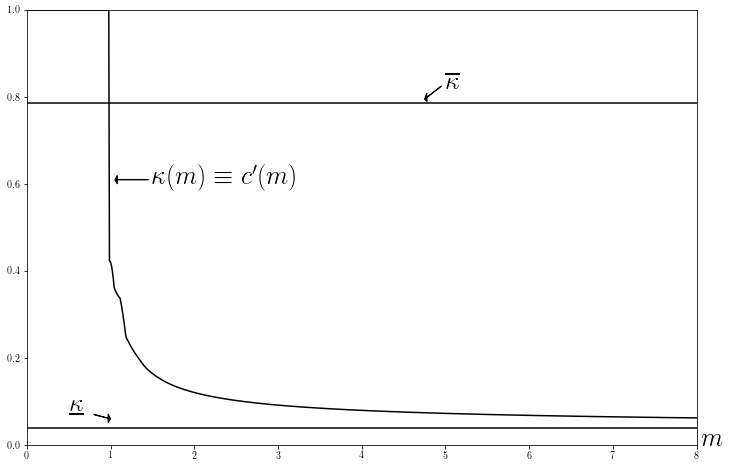

In [10]:
# The last figure shows the upper and lower limits of the MPC
plt.figure(figsize = (12,8))
# Set the plot range of m
m = np.linspace(0.001,8,1000)

# Use the HARK method derivative to get the derivative of cFunc, and the values are just the MPC
MPC = model_HARK.cFunc[0].derivative(m)

# Define the upper bound of MPC
MPCUpper = (1 - model_HARK.UnempPrb ** (1.0/model_HARK.CRRA)*(model_HARK.Rfree*model_HARK.DiscFac)**(1.0/model_HARK.CRRA)/model_HARK.Rfree)

# Define the lower bound of MPC
MPCLower = k_lower

kappaDef=r'$\underline{\kappa}$'
if not iflatexExists:
    kappaDef=r'κ̲$\equiv(1-\Phi_{R})$'

plt.plot(m,MPC,color = 'black')
plt.plot([0,8],[MPCUpper,MPCUpper],color = 'black')
plt.plot([0,8],[MPCLower,MPCLower],color = 'black')
plt.xlim(0,8)
plt.ylim(0,1)
plt.text(1.5,0.6,r'$\kappa(m) \equiv c^{\prime}(m)$',fontsize = 26,fontweight='bold')
plt.arrow(1.45,0.61,-0.4,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

if iflatexExists:
    plt.text(5,.82,r'$\overline{\kappa}$',fontsize = 26,fontweight='bold')
else:
    plt.text(5,0.82,r'$(1-\wp^{1/\rho}\Phi_{R})\equiv \overline{\kappa}$',fontsize = 26,fontweight='bold')
plt.arrow(4.95,0.825,-0.2,-0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

plt.text(0.5,0.07,kappaDef,fontsize = 26,fontweight='bold')
plt.text(8.05,0,"$m$",fontsize = 26)
plt.arrow(.8,0.07,0.2,-0.01,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.svg'))
if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted